Notebook from: https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings-v2

# M5 Forecast: Keras with Categorical Embeddings V2

This notebook tries to model expected sales of product groups. Since many of the features are categorical, we use this example to show how embedding layers make life easy when dealing with categoric inputs for neural nets by skipping the step of making dummy variables by hand.

Data preprocessing and feature engineering is very similar (but not identical) to this [R kernel](https://www.kaggle.com/mayer79/m5-forecast-keras-embeddings-with-r) and uses ideas from the two excellent kernels [Very fst Model](https://www.kaggle.com/ragnar123/very-fst-model) and [M5 ForecasteR](https://www.kaggle.com/kailex/m5-forecaster-0-57330).

To gain an extra 3 GB of RAM, we do not use GPU acceleration for the training.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from tqdm.notebook import tqdm

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load data

In [3]:
path = "../input/m5-forecasting-accuracy"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [4]:
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

## Describe and prepare data

We will now go through all data sets and prepare them for modelling.

### Calendar data

For each date (covering both training and test data), we have access to useful calendar information.

In [5]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


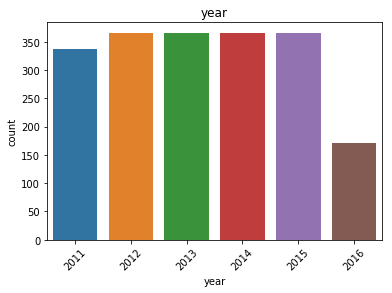

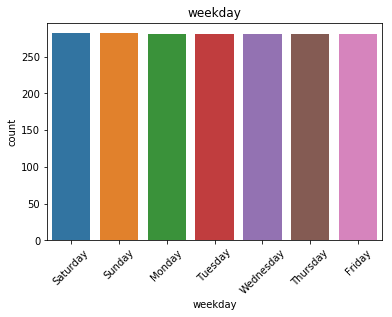

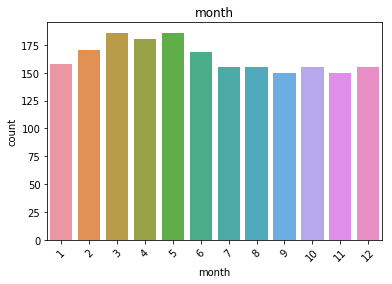

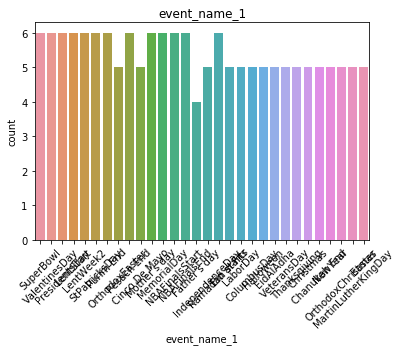

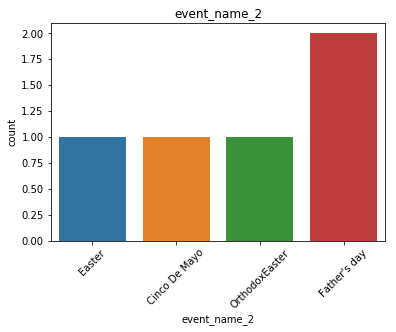

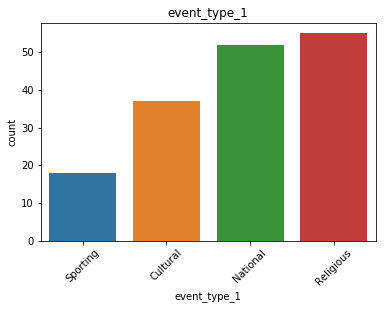

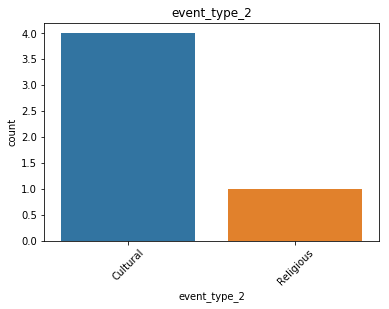

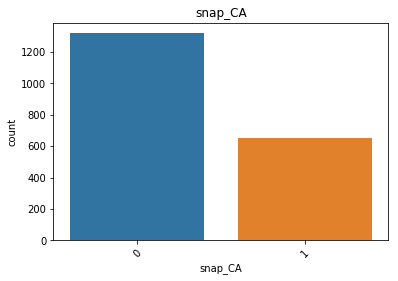

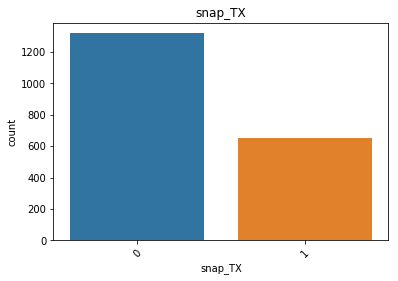

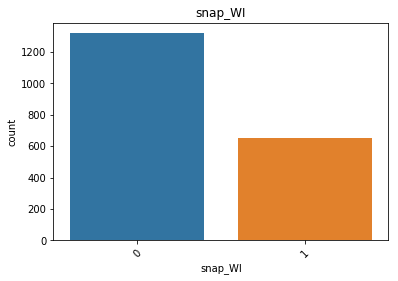

In [6]:
for i, var in enumerate(["year", "weekday", "month", "event_name_1", "event_name_2", 
                         "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]):
    plt.figure()
    g = sns.countplot(calendar[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [7]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar)

Mem. usage decreased to  0.03 Mb (85.4% reduction)


In [8]:
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


#### Notes for modeling

**Features** deemed to be useful:

- "wday", "year", "month" -> integer coding & embedding
- "event_name_1", "event_type_1" -> integer coding & embedding
- "snap_XX" -> numeric (they are dummies)

**Reshape required**: No

**Merge key(s)**: "d", "wm_yr_wk"

### Selling prices

Contains selling prices for each store_id, item_id_wm_yr_wk combination.

In [9]:
selling_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      object
item_id       object
wm_yr_wk      int64
sell_price    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


Derive some time related features:

In [10]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

selling_prices = prep_selling_prices(selling_prices)

Mem. usage decreased to 169.63 Mb (53.6% reduction)


In [11]:
selling_prices.tail()

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
6841116,WI_3,FOODS_3_827,11617,1.0,0.0,0.0,0.0
6841117,WI_3,FOODS_3_827,11618,1.0,0.0,0.0,0.0
6841118,WI_3,FOODS_3_827,11619,1.0,0.0,0.0,0.0
6841119,WI_3,FOODS_3_827,11620,1.0,0.0,0.0,0.0
6841120,WI_3,FOODS_3_827,11621,1.0,0.0,0.0,0.0


#### Notes for modeling

**Features**:

- sell_price and derived features -> numeric

**Reshape**: No

**Merge key(s)**: to sales data by store_id, item_id, wm_yr_wk (through calendar data)

### Sales data

Contains the number of sold items (= our response) as well as some categorical features.

In [12]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


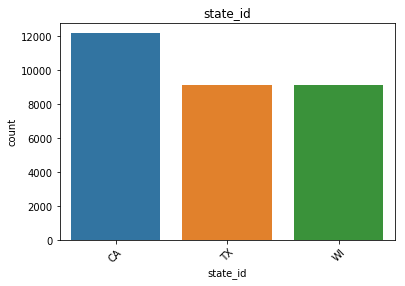

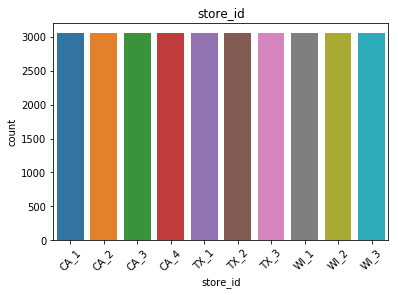

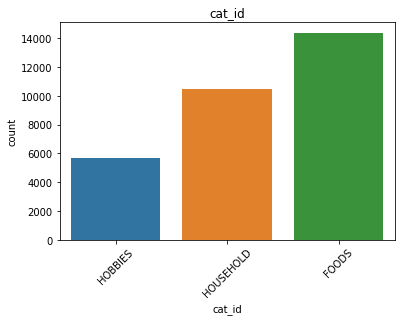

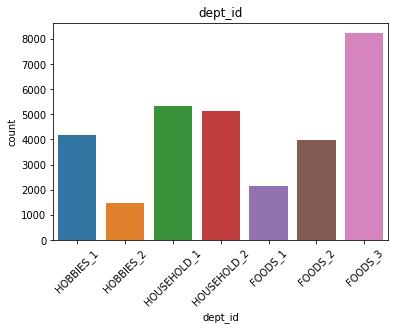

In [13]:
for i, var in enumerate(["state_id", "store_id", "cat_id", "dept_id"]):
    plt.figure()
    g = sns.countplot(sales[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [14]:
sales.item_id.value_counts()

FOODS_2_004        10
FOODS_1_218        10
HOBBIES_1_315      10
HOUSEHOLD_1_227    10
FOODS_3_037        10
                   ..
HOUSEHOLD_1_173    10
FOODS_3_173        10
FOODS_2_348        10
HOUSEHOLD_2_392    10
HOUSEHOLD_2_058    10
Name: item_id, Length: 3049, dtype: int64

#### Reshaping

We now reshape the data from wide to long, using "id" as fixed and swapping "d_x" columns. Along this process, we also add structure for submission data and reduce data size.

In [15]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

sales = reshape_sales(sales, 1000)

In [16]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1001,1.0


#### Distribution of the response

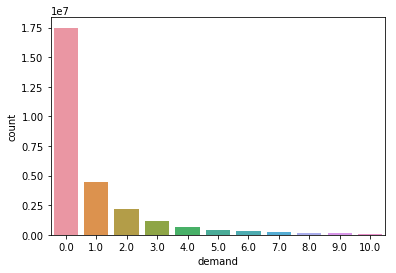

In [17]:
sns.countplot(sales["demand"][sales["demand"] <= 10]);

#### Add time-lagged features

Add some of the derived features from kernel https://www.kaggle.com/ragnar123/very-fst-model.

In [18]:
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())

    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
    df = reduce_mem_usage(df)

    return df

sales = prep_sales(sales)

Mem. usage decreased to 1683.94 Mb (41.5% reduction)


In [19]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
6311430,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582
6311431,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150
6311432,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027
6311433,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828
6311434,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527


In [20]:
sales.d.unique().shape

(762,)

#### Notes for modeling

**Features**
- "dept_id", "item_id", "store_id": Integer coding & embedding
- lagged features derived from response: Numeric

**Reshape**:
- Reshape days as "d" from wide to long -> "demand" will be response variable

**Merges**:
1. Join calendar features by "d"
2. Join selling prices by "store_id", "item_id" and ("wm_yr_wk" from calendar)

Comment: Submission dates: "d_1914" - "d_1969"

### Combine data sources

In [21]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,...,3,4,3,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,...,3,4,3,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,...,3,4,3,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,...,3,4,3,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,...,3,4,3,30,4,4,2,0,0,0


In [22]:
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,...,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,...,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,...,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,...,4,4,2,0,0,0,4.640625,0.0,0.0,0.230713
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,...,4,4,2,0,0,0,3.080078,0.0,0.0,0.375000


In [23]:
del selling_prices

In [24]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23233380 entries, 0 to 23233379
Data columns (total 30 columns):
id                     object
item_id                object
dept_id                object
cat_id                 object
store_id               object
state_id               object
d                      int16
demand                 float16
lag_t28                float16
rolling_mean_t7        float16
rolling_mean_t30       float16
rolling_mean_t60       float16
rolling_mean_t90       float16
rolling_mean_t180      float16
rolling_std_t7         float16
rolling_std_t30        float16
wday                   int8
month                  int8
year                   int8
event_name_1           int8
event_type_1           int8
event_name_2           int8
event_type_2           int8
snap_CA                int8
snap_TX                int8
snap_WI                int8
sell_price             float16
sell_price_rel_diff    float16
sell_price_roll_sd7    float16
sell_price_cumrel      f

## Prepare data for Keras interface

### Ordinal encoding of remaining categoricals

In [25]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)
sales.head()
gc.collect()


Mem. usage decreased to 1329.42 Mb (36.2% reduction)


5

#### Impute numeric columns

In [26]:
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
            "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1208,2.0,0.0,0.714355,...,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,1208,1.0,1.0,0.285645,...,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,1208,1.0,0.0,0.285645,...,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,1208,1.0,4.0,2.572266,...,4,4,2,0,0,0,4.640625,0.0,0.0,0.230713
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,1208,0.0,0.0,1.000000,...,4,4,2,0,0,0,3.080078,0.0,0.0,0.375000


#### Separate submission data and reconstruct id columns

In [27]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test.head()
gc.collect()

24

#### Make training data

In [28]:
# Input dict for training with a dense array and separate inputs for each embedding input
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

# Submission data
X_test = make_X(test)

# One month of validation data
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = (make_X(sales[flag]),
         sales["demand"][flag])

# Rest is used for training
flag = sales.d < 1914 - 28
X_train = make_X(sales[flag])
y_train = sales["demand"][flag]
                             
del sales, flag
gc.collect()

0

In [29]:
np.unique(X_train["state_id"])

array([0, 1, 2], dtype=int8)

## The model

### Imports

In [30]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, LSTM, Reshape
from tensorflow.keras.models import Model

### Architecture with embeddings

In [31]:
def create_model(lr=0.002):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(batch_shape=(30490, len(dense_cols)), name='dense1')

    # Embedding input
    wday_input = Input(batch_shape=(30490, 1), name='wday')
    month_input = Input(batch_shape=(30490, 1), name='month')
    year_input = Input(batch_shape=(30490, 1),name='year')
    event_name_1_input = Input(batch_shape=(30490, 1), name='event_name_1')
    event_type_1_input = Input(batch_shape=(30490, 1), name='event_type_1')
    event_name_2_input = Input(batch_shape=(30490, 1), name='event_name_2')
    event_type_2_input = Input(batch_shape=(30490, 1), name='event_type_2')
    item_id_input = Input(batch_shape=(30490, 1), name='item_id')
    dept_id_input = Input(batch_shape=(30490, 1), name='dept_id')
    store_id_input = Input(batch_shape=(30490, 1), name='store_id')
    cat_id_input = Input(batch_shape=(30490, 1), name='cat_id')
    state_id_input = Input(batch_shape=(30490, 1), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Reshape((29,1))(x)
    x = LSTM(20, activation="tanh",input_shape=(29,1),stateful=True)(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wday (InputLayer)               [(30490, 1)]         0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(30490, 1)]         0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(30490, 1)]         0                                            
__________________________________________________________________________________________________
event_name_1 (InputLayer)       [(30490, 1)]         0                                            
______________________________________________________________________________________________

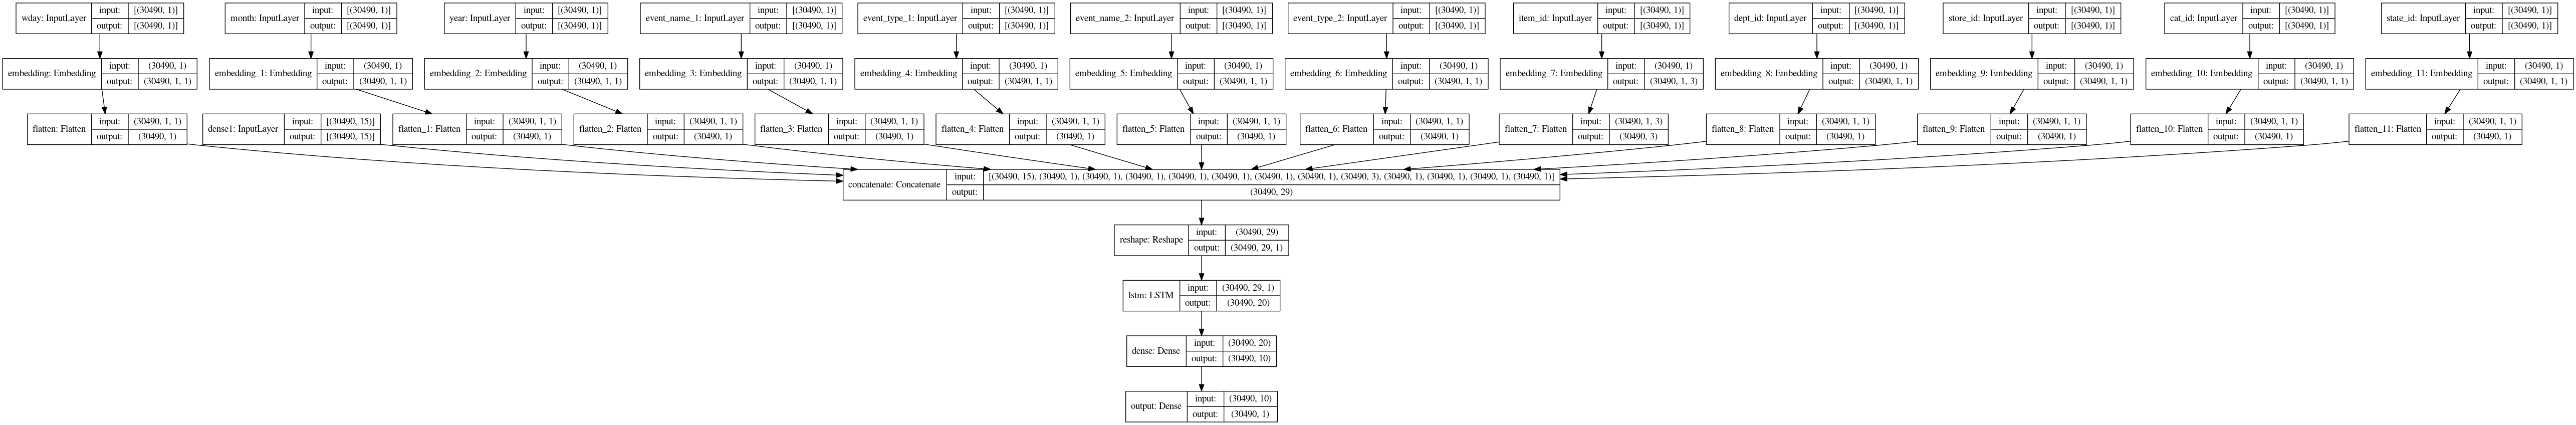

In [32]:
model = create_model(0.001)
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

### Calculate derivatives and fit model

In [33]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=30490,
                    epochs=30,
                    shuffle=False,
                    validation_data=valid)

Train on 20672220 samples, validate on 853720 samples
Epoch 1/30
20672220/20672220 [==============================] - 463s 22us/sample - loss: 9.3922 - mse: 9.3922 - val_loss: 7.9164 - val_mse: 7.9164
Epoch 2/30
20672220/20672220 [==============================] - 443s 21us/sample - loss: 7.8439 - mse: 7.8440 - val_loss: 6.9368 - val_mse: 6.9368
Epoch 3/30
20672220/20672220 [==============================] - 447s 22us/sample - loss: 7.1628 - mse: 7.1628 - val_loss: 6.3993 - val_mse: 6.3993
Epoch 4/30
20672220/20672220 [==============================] - 452s 22us/sample - loss: 6.7407 - mse: 6.7407 - val_loss: 6.0327 - val_mse: 6.0327
Epoch 5/30
20672220/20672220 [==============================] - 448s 22us/sample - loss: 6.4637 - mse: 6.4637 - val_loss: 5.8348 - val_mse: 5.8348
Epoch 6/30
20672220/20672220 [==============================] - 457s 22us/sample - loss: 6.2676 - mse: 6.2676 - val_loss: 5.7250 - val_mse: 5.7250
Epoch 7/30
20672220/20672220 [==============================] - 

#### Plot the evaluation metrics over epochs

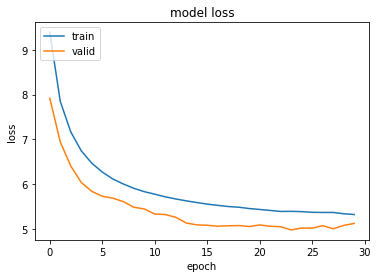

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [35]:
history.history["val_loss"]

[7.916447111538479,
 6.936797891344343,
 6.399305599076407,
 6.032661088875362,
 5.834775405270713,
 5.724960233483996,
 5.682418150561197,
 5.605685779026577,
 5.479123507227216,
 5.441077530384064,
 5.327070534229279,
 5.316323646477291,
 5.254949126924787,
 5.1266297698020935,
 5.084700005395072,
 5.076006659439632,
 5.0551139031137735,
 5.064242686544146,
 5.0693439330373495,
 5.04794009242739,
 5.082982020718711,
 5.054506719112396,
 5.042971874986376,
 4.971950675759997,
 5.014033726283482,
 5.011268973350525,
 5.067505810941968,
 4.9979647397994995,
 5.07207909652165,
 5.116881447178977]

In [36]:
model.save('model.h5')

## Submission

In [37]:
pred = model.predict(X_test, batch_size=30490)

In [38]:
test["demand"] = pred.clip(0)
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.687041,0.574870,0.532341,0.527915,0.531987,0.534157,0.704898,0.561710,1.296221,...,0.744555,1.186131,0.809926,0.714100,0.700292,0.702830,0.915528,0.725912,0.782241,0.786467
1,HOBBIES_1_002_CA_1_validation,0.296867,0.244610,0.241622,0.227577,0.181190,0.147665,0.256915,0.176977,0.207255,...,0.128356,0.113997,0.180475,0.177787,0.216318,0.273717,0.219694,0.157133,0.109482,0.102947
2,HOBBIES_1_003_CA_1_validation,0.227294,0.235978,0.235409,0.232715,0.197803,0.145654,0.373147,0.222417,0.246653,...,0.443511,0.380156,0.600191,0.411064,0.410619,0.416805,0.326076,0.377231,0.378746,0.346112
3,HOBBIES_1_004_CA_1_validation,1.863471,1.657363,1.581037,1.478950,1.920499,1.812100,1.909103,1.608067,1.872026,...,1.756990,1.836132,2.661275,1.912643,1.522641,1.394179,1.391773,1.767732,2.889871,2.192882
4,HOBBIES_1_005_CA_1_validation,0.798021,0.655241,0.986430,1.166415,0.960503,1.139925,1.807042,1.248418,1.326111,...,1.072435,1.086261,1.139818,0.790258,0.816481,0.820830,0.916081,0.968587,1.110920,1.418452


In [39]:
submission[sample_submission.id=="FOODS_1_001_TX_2_validation"].head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
16857,FOODS_1_001_TX_2_validation,0.429873,0.428894,0.424819,0.677726,0.498125,0.440962,0.57333,0.506445,0.539292,...,0.72023,0.502817,0.639509,0.464768,0.460118,0.457306,0.446512,0.356985,0.409722,0.320894


In [40]:
submission.to_csv("submission.csv", index=False)